# GNN learning

## 基本模型学习

### GCN(图卷积神经网络)

#### 数据导入与处理

In [ ]:
from spektral.datasets import TUDataset
import numpy as np


dataset = TUDataset('PROTEINS')

dataset.map(lambda g: g.n_nodes < 500)
np.random.shuffle(dataset)
train_data, valid_data, test_data = dataset[0:int(len(dataset)*0.6)], \
                                    dataset[int(len(dataset)*0.6):int(len(dataset)*0.8)], \
                                    dataset[int(len(dataset)*0.8):]

#### 模型搭建

In [5]:
from spektral.layers import GCNConv, GlobalSumPool
from keras.api._v2.keras.models import Model
from keras.api._v2.keras.layers import Input, Dropout, Dense


class MyGCN(Model):

    def __init__(self, n_hidden, n_labels):
        super(MyGCN, self).__init__()
        self.conv1 = GCNConv(n_hidden, activation="relu")
        self.pool1 = GlobalSumPool()
        self.dense = Dense(n_labels, activation="softmax")

    def call(self, inputs):  # 定义一个名为call的方法，用于处理输入数据
        x, a = inputs
        x = self.conv1([x, a])
        x = self.pool1(x)
        x = self.dense(x)

        return x
    

model = MyGCN(16, dataset.n_labels)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])

#### 模型训练

Epoch 1/100
21/21 [==============================] - 0s 16ms/step - loss: 6.2554 - acc: 0.6507 - val_loss: 6.7178 - val_acc: 0.6682
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 5.7749 - acc: 0.6447 - val_loss: 6.6262 - val_acc: 0.6502
Epoch 3/100
21/21 [==============================] - 0s 16ms/step - loss: 5.5952 - acc: 0.6777 - val_loss: 7.7768 - val_acc: 0.5695
Epoch 4/100
21/21 [==============================] - 0s 16ms/step - loss: 5.0228 - acc: 0.6747 - val_loss: 7.5908 - val_acc: 0.6233
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 4.7968 - acc: 0.6642 - val_loss: 4.1352 - val_acc: 0.6861
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 4.4243 - acc: 0.6792 - val_loss: 5.1315 - val_acc: 0.6502
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 4.1166 - acc: 0.6927 - val_loss: 6.4231 - val_acc: 0.5874
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 3.

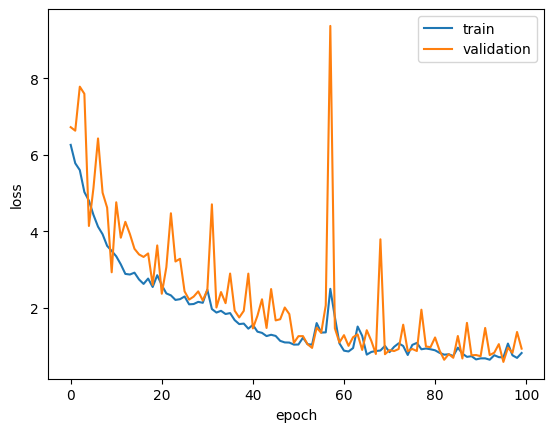

In [7]:
from spektral.data import BatchLoader
import matplotlib.pyplot as plt


loader_train = BatchLoader(train_data, batch_size=32)
loader_valid = BatchLoader(valid_data, batch_size=32)
model.fit(loader_train.load(),
          validation_data=loader_valid.load(),
          steps_per_epoch=loader_train.steps_per_epoch,
          validation_steps=loader_valid.steps_per_epoch,
          epochs=100,
          shuffle=False)
model.summary()

# plot
history = model.history.history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 模型测试

In [8]:
loader = BatchLoader(test_data, batch_size=32)
accuracy = model.evaluate(loader.load(), 
                          steps=loader.steps_per_epoch)[1]
print(f"Test accuracy: {accuracy}")

7/7 [==============================] - 0s 8ms/step - loss: 1.1337 - acc: 0.7489
Test accuracy: 0.7488788962364197


### GraphSAGE(图采样与聚合)

#### 数据导入与处理

In [ ]:
from spektral.datasets import TUDataset
import numpy as np


dataset = TUDataset('PROTEINS')

dataset.map(lambda g: g.n_nodes < 500)
np.random.shuffle(dataset)
train_data, valid_data, test_data = dataset[0:int(len(dataset)*0.6)], \
                                    dataset[int(len(dataset)*0.6):int(len(dataset)*0.8)], \
                                    dataset[int(len(dataset)*0.8):]

C:\Users\19596\AppData\Local\Temp\ipykernel_25864\1596129766.py:5: UserWarning: you are shuffling a 'TUDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset)


#### 模型搭建

In [35]:
import tensorflow as tf
from spektral.layers import GraphSageConv, GlobalSumPool
from keras.api._v2.keras.models import Model
from keras.api._v2.keras.layers import Input, Dropout, Dense


class MyGraphSage(Model):
    
    def __init__(self, n_labels):
        super(MyGraphSage, self).__init__()
        self.conv1 = GraphSageConv(16, aggregate='mean', activation="relu")
        self.pool1 = GlobalSumPool()
        self.dense = Dense(n_labels, activation="softmax")

    def call(self, inputs):  # 定义一个名为call的方法，用于处理输入数据
        x, a = inputs
        x = tf.cast(x, tf.float32)  # 将输入数据转换为float32类型
        a = tf.cast(a, tf.float32)
        a = tf.sparse.from_dense(a)
        x = self.conv1([x, a])
        x = self.pool1(x)
        x = self.dense(x)

        return x  # 返回最终的输出结果
    

model = MyGraphSage(dataset.n_labels)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])

#### 模型训练

Epoch 1/100
21/21 [==============================] - 2s 34ms/step - loss: 15.0074 - acc: 0.6072 - val_loss: 6.9826 - val_acc: 0.6009
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 4.4218 - acc: 0.6432 - val_loss: 1.5807 - val_acc: 0.6816
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 1.7493 - acc: 0.6117 - val_loss: 1.4178 - val_acc: 0.6502
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 1.4453 - acc: 0.6927 - val_loss: 1.3416 - val_acc: 0.6682
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 1.3681 - acc: 0.6837 - val_loss: 1.1478 - val_acc: 0.6771
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 1.1055 - acc: 0.6942 - val_loss: 1.0664 - val_acc: 0.6726
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 1.1196 - acc: 0.6702 - val_loss: 0.9968 - val_acc: 0.6323
Epoch 8/100
21/21 [==============================] - 0s 15ms/step - loss: 0

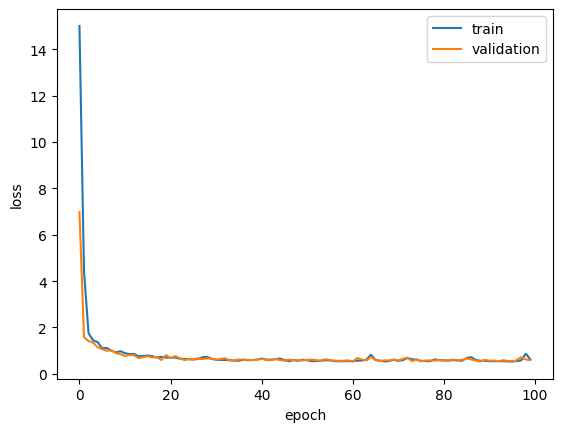

In [36]:
from spektral.data import BatchLoader
import matplotlib.pyplot as plt


loader_train = BatchLoader(train_data, batch_size=32)
loader_valid = BatchLoader(valid_data, batch_size=32)
model.fit(loader_train.load(),
          validation_data=loader_valid.load(),
          steps_per_epoch=loader_train.steps_per_epoch,
          validation_steps=loader_valid.steps_per_epoch,
          epochs=100,
          shuffle=False)
model.summary()

# plot
history = model.history.history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 模型测试

In [37]:
loader = BatchLoader(test_data, batch_size=32)
accuracy = model.evaluate(loader.load(), 
                          steps=loader.steps_per_epoch)[1]
print(f"Test accuracy: {accuracy}")

7/7 [==============================] - 0s 13ms/step - loss: 0.5792 - acc: 0.7399
Test accuracy: 0.7399103045463562


### GAT(图注意力网络)

#### 数据导入与处理

In [14]:
from spektral.datasets import TUDataset
import numpy as np


dataset = TUDataset('PROTEINS')

dataset.map(lambda g: g.n_nodes < 500)
np.random.shuffle(dataset)
train_data, valid_data, test_data = dataset[0:int(len(dataset)*0.6)], \
                                    dataset[int(len(dataset)*0.6):int(len(dataset)*0.8)], \
                                    dataset[int(len(dataset)*0.8):]

Successfully loaded PROTEINS.


C:\Users\19596\AppData\Local\Temp\ipykernel_25864\1801351208.py:8: UserWarning: you are shuffling a 'TUDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(dataset)


#### 模型搭建

In [38]:
import tensorflow as tf
from spektral.layers import GATConv
from keras.api._v2.keras.models import Model
from keras.api._v2.keras.layers import Input, Dropout, Dense
from tensorflow.keras.optimizers import Adam

class MyGAT(Model):  
    
    def __init__(self, n_labels):
        super(MyGAT, self).__init__()
        self.conv1 = GATConv(16, attn_heads=3, concat_heads=True, activation="relu")
        self.pool1 = GlobalSumPool()
        self.dense = Dense(n_labels, activation="softmax")

    def call(self, inputs):  # 定义一个名为call的方法，用于处理输入数据
        x, a = inputs
        x = tf.cast(x, tf.float32)  # 将输入数据转换为float32类型
        a = tf.cast(a, tf.float32)
        x = self.conv1([x, a])
        x = self.pool1(x)
        x = self.dense(x)

        return x  # 返回最终的输出结果
    

model = MyGAT(dataset.n_labels)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])

#### 模型训练

Epoch 1/100
21/21 [==============================] - 1s 32ms/step - loss: 2.6922 - acc: 0.6192 - val_loss: 1.3054 - val_acc: 0.6816
Epoch 2/100
21/21 [==============================] - 0s 19ms/step - loss: 2.1454 - acc: 0.6102 - val_loss: 1.7883 - val_acc: 0.6547
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 1.8833 - acc: 0.6132 - val_loss: 1.4265 - val_acc: 0.6637
Epoch 4/100
21/21 [==============================] - 0s 22ms/step - loss: 1.8946 - acc: 0.6102 - val_loss: 1.1120 - val_acc: 0.6816
Epoch 5/100
21/21 [==============================] - 0s 23ms/step - loss: 1.7048 - acc: 0.6327 - val_loss: 0.9421 - val_acc: 0.6771
Epoch 6/100
21/21 [==============================] - 0s 21ms/step - loss: 1.7542 - acc: 0.6177 - val_loss: 1.3806 - val_acc: 0.6457
Epoch 7/100
21/21 [==============================] - 0s 20ms/step - loss: 1.4205 - acc: 0.6237 - val_loss: 0.8196 - val_acc: 0.7220
Epoch 8/100
21/21 [==============================] - 0s 22ms/step - loss: 1.

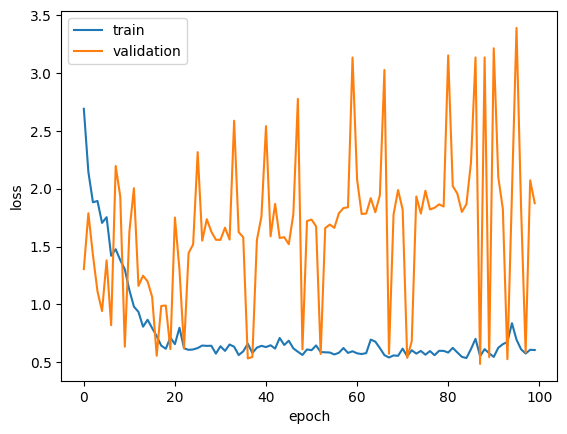

In [39]:
from spektral.data import BatchLoader
import matplotlib.pyplot as plt


loader_train = BatchLoader(train_data, batch_size=32)
loader_valid = BatchLoader(valid_data, batch_size=32)
model.fit(loader_train.load(),
          validation_data=loader_valid.load(),
          steps_per_epoch=loader_train.steps_per_epoch,
          validation_steps=loader_valid.steps_per_epoch,
          epochs=100,
          shuffle=False)
model.summary()

# plot
history = model.history.history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 模型测试

In [40]:
loader = BatchLoader(test_data, batch_size=32)
accuracy = model.evaluate(loader.load(), 
                          steps=loader.steps_per_epoch)[1]
print(f"Test accuracy: {accuracy}")

7/7 [==============================] - 0s 17ms/step - loss: 8.4175 - acc: 0.7265
Test accuracy: 0.726457417011261


### EDGE(边卷积网络)